# 04. Performance Profiling

We can profile the performance with a 3D FDTD simulation:

## Imports

In [14]:
import matplotlib.pyplot as plt
from line_profiler import LineProfiler

import fdtd
import fdtd.backend as bd

## Set Backend

Let's profile the impact of the backend. These are the possible backends:

- ``numpy`` (defaults to float64 arrays)
- ``torch`` (defaults to float64 tensors)
- ``torch.float32``
- ``torch.float64``
- ``torch.cuda`` (defaults to float64 tensors)
- ``torch.cuda.float32``
- ``torch.cuda.float64``

In [15]:
fdtd.set_backend("numpy")

In general, the ``numpy`` backend is preferred for standard CPU calculations
with `"float64"` precision as it is slightly faster than ``torch`` backend on CPU. However, a significant performance improvement can be obtained by choosing ``torch.cuda`` on large enough grids.

Note that, in FDTD, ``float64`` precision is generally preferred over ``float32`` to ensure numerical stability and prevent numerical dispersion. If this is of no concern to you, you can opt for ``float32`` precision, which especially on a GPU might yield a significant performance boost.

## Constants

In [16]:
WAVELENGTH = 1550e-9
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light

## Setup Simulation

create FDTD Grid

In [17]:
N = 100

grid = fdtd.Grid(
    (N, N, N),
    grid_spacing=0.05 * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
)

add boundaries

In [18]:
# x boundaries
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

# z boundaries
grid[:, :, 0:10] = fdtd.PML(name="pml_zlow")
grid[:, :, -10:] = fdtd.PML(name="pml_zhigh")

add sources

In [19]:
grid[10+N//10:10+N//10, :, :] = fdtd.PlaneSource(
    period=WAVELENGTH / SPEED_LIGHT, name="source"
)

add objects

In [20]:
grid[10+N//5:4*N//5-10, 10+N//5:4*N//5-10, 10+N//5:4*N//5-10] = fdtd.Object(permittivity=2.5, name="center_object")

grid summary

In [21]:
print(grid)

Grid(shape=(100,100,100), grid_spacing=2.46e-08, courant_number=0.57)

sources:
    PlaneSource(period=35, amplitude=1.0, phase_shift=0.0, name='source', polarization='z')
        @ x=[20, ... , 21], y=[0, ... , 100], z=[0, ... , 100]

boundaries:
    PML(name='pml_xlow')
        @ x=0:10, y=:, z=:
    PML(name='pml_xhigh')
        @ x=-10:, y=:, z=:
    PML(name='pml_ylow')
        @ x=:, y=0:10, z=:
    PML(name='pml_yhigh')
        @ x=:, y=-10:, z=:
    PML(name='pml_zlow')
        @ x=:, y=:, z=0:10
    PML(name='pml_zhigh')
        @ x=:, y=:, z=-10:

objects:
    Object(name='center_object')
        @ x=30:70, y=30:70, z=30:70



## Setup LineProfiler

create and enable profiler

In [10]:
profiler = LineProfiler()
profiler.add_function(grid.update_E)
profiler.enable()

## Run Simulation

run simulation

In [11]:
grid.run(50, progress_bar=True)

100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.74it/s]


## Profiler Results

print profiler summary

In [12]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 5.30356 s
File: C:\Users\49157\anaconda3\envs\FDTD\lib\site-packages\fdtd\grid.py
Function: update_E at line 275

Line #      Hits         Time  Per Hit   % Time  Line Contents
   275                                               def update_E(self):
   276                                                   """update the electric field by using the curl of the magnetic field"""
   277                                           
   278                                                   # update boundaries: step 1
   279       300       4473.0     14.9      0.0          for boundary in self.boundaries:
   280       300   16106946.0  53689.8     30.4              boundary.update_phi_E()
   281                                           
   282        50   19913864.0 398277.3     37.5          curl = curl_H(self.H)
   283        50    8978805.0 179576.1     16.9          self.E += self.courant_number * self.inverse_permittivity * curl
   284                     

## Visualization

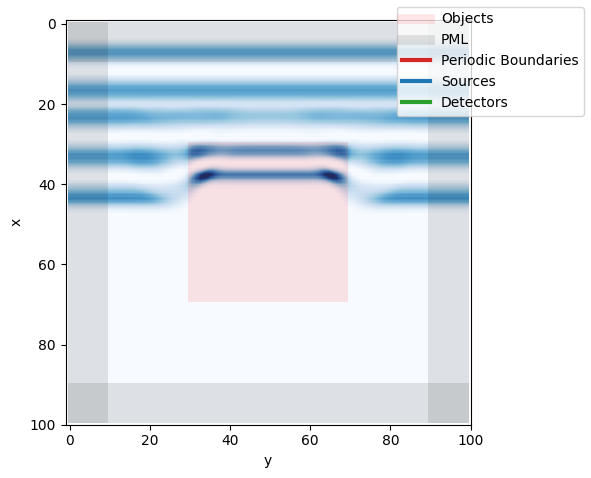

In [13]:
plt.figure()
grid.visualize(z=N//2)